In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal 


### The code below has been adapted from: https://github.com/georgedimitriadis/themeaningofbrain

def split_list_pairwise(l,p):
    groups = []
    prev = None
    group = None
    for x in l:
        if prev is None or p(x,prev):
            group = []
            groups.append(group)
        group.append(x)
        prev = x
    return groups


def custom_find_peaks(data_raw_spikes, threshold, inter_spike_time_distance=30, amp_gain=100,
                                  sampling_freq=30000, amp_y_digitization=65536, amp_y_range=10):

    scaling_factor = amp_y_range / (amp_y_digitization * amp_gain)
    data_in_v = (data_raw_spikes - np.mean(data_raw_spikes)) * scaling_factor

    derivative = np.diff(np.sign(np.diff(data_in_v))) #check when deriv changes sign
    if threshold > 0:
        derivative = derivative < 0
    else:
        derivative = derivative > 0

    peaks = np.flatnonzero(derivative) + 1  # local max
    if threshold > 0:
        peaks = peaks[data_in_v[peaks] > threshold]
    else:
        peaks = peaks[data_in_v[peaks] < threshold]

    if inter_spike_time_distance > 0:
        gpeaks = split_list_pairwise(peaks, lambda x, p: x - p > inter_spike_time_distance)
        peaks = np.array([g[np.argmax([data_in_v[i] for i in g])] for g in gpeaks])
    return peaks, data_in_v

In [2]:
data_folder = '2014_11_13_Pair_3_0'
Sampling_frequency = 30_000  #Hz
Probe_numChannels = 32
Probe_dtype = np.uint16
Probe_voltage_step_size = 0.195e-6
Probe_y_digitization = 32768
Juxta_numChannels = 8
Juxta_dtype = np.uint16
Juxta_ADC_used_channel = 0
Juxta_Gain = 100
Juxta_y_digitization = 65536
Juxta_y_range = 10
distance_min = 172 #(µm) 
Probe_closest_electrode = 17


# Load data from bin files into a matrix of n channels x m samples 
def loadRawData(filename, numChannels, dtype):
    
    fdata = np.fromfile(filename,dtype=dtype)
    assert len(fdata) % numChannels == 0
    numsamples = len(fdata) // numChannels
    data = np.reshape(fdata,(numsamples, numChannels))
    
    return np.transpose(data)


In [3]:
# Open ADC file 
# (juxtacellular recording from the juxtacellular micropipette -- frequency band from 300 to 7500 Hz)

filename = f"{data_folder}/adc2014-11-13T18_48_11.bin"
juxta_threshold = 1e-3 #using the one in paired_32ch.py! NOT the one in DataSummary.xlsx
inter_spike_time_distance = 30 # (30 samples = 1 ms)

juxta = loadRawData(filename, numChannels = Juxta_numChannels, dtype = Juxta_dtype)
# the rescaling below (from 2014_11_13_Pair_1_0_Software.docx) looks wrong! 
# juxta_channel_Volts = juxta [Juxta_ADC_used_channel, :] * (Juxta_y_range /( Juxta_y_digitization * Juxta_Gain))
# based on the code for the IO.ephys.find_peaks function, must substract the mean first in order to use the threshold
# value provided in DataSummary.xlsx


# Generate the spike time triggers (and the adc traces in Volts) for the cell recorded juxta cellularly

spike_triggers, spike_data_in_V = custom_find_peaks(juxta[Juxta_ADC_used_channel],
                                                    threshold=juxta_threshold,
                                                    inter_spike_time_distance=inter_spike_time_distance,
                                                    amp_gain=Juxta_Gain,
                                                    amp_y_range=Juxta_y_range)

num_of_spikes = len(spike_triggers)
num_of_spikes

2004

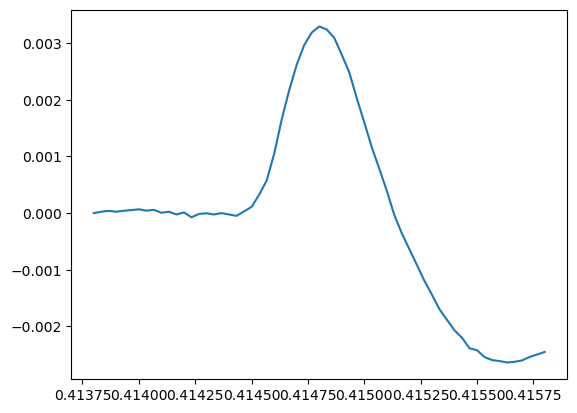

In [8]:
### Plot a single spike

peak_i = 0
window_half_size = 30 #1 ms = 30
ix = spike_triggers[peak_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size + 1)
plt.plot(window_ixs / Sampling_frequency, spike_data_in_V[window_ixs])

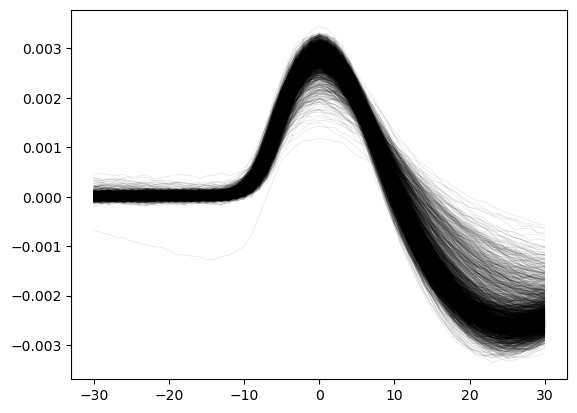

In [9]:
### Plot all spikes on top of each other

import matplotlib.pyplot as plt
window_half_size = 30 #1 ms = 30
for peak_i in range(len(spike_triggers)):
    
    ix = spike_triggers[peak_i]
    window_ixs = np.arange(ix - window_half_size, ix + window_half_size + 1)
    plt.plot(range(-window_half_size,window_half_size+1), spike_data_in_V[window_ixs], lw=0.5, c='k', alpha=0.1)
    
plt.show()

In [56]:
# Open Amplifier file 
from scipy import signal
# (extracellular recording from a silicon polytrode with 32 or 128 electrodes -- frequency band from 0.1 to 7500 Hz)

filename = f"{data_folder}/amplifier2014-11-13T18_48_11.bin"
extra = loadRawData(filename, numChannels = Probe_numChannels, dtype = Probe_dtype) 

extra_Volts = (extra - Probe_y_digitization) * Probe_voltage_step_size

filtered_data_type = np.float32
num_of_points_in_spike_trig_ivm = 128
num_of_points_for_padding = num_of_points_in_spike_trig_ivm//2

#Filter for extracellular recording
def highpass(data,BUTTER_ORDER=3, F_HIGH=14250,sampleFreq=Sampling_frequency,passFreq=100.0):
    b, a = signal.butter(BUTTER_ORDER,(passFreq/(sampleFreq/2.), F_HIGH/(sampleFreq/2.)),'pass')
    return signal.filtfilt(b,a,data)

shape_spike_data = (num_of_spikes, Probe_numChannels, num_of_points_in_spike_trig_ivm)
ivm_data_filtered = np.zeros(shape_spike_data, dtype=filtered_data_type)
ivm_data_unfiltered = np.zeros(shape_spike_data, dtype=extra_Volts.dtype)

for spike_i in range(num_of_spikes):
    if (spike_i + 1) % 25 == 0:
        print(spike_i +1, end=' ', flush=True)

    trigger_point = spike_triggers[spike_i]
    start_point = int(trigger_point - (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    assert start_point >= 0
    end_point = int(trigger_point + (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    if end_point > extra.shape[1]:
        break
        
    temp_unfiltered = extra_Volts[:, start_point:end_point].astype(filtered_data_type)
    ivm_data_unfiltered[spike_i] = temp_unfiltered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    temp_filtered = highpass(temp_unfiltered)
    temp_filtered = temp_filtered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    ivm_data_filtered[spike_i] = temp_filtered
print()


25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 1875 1900 1925 1950 1975 2000 


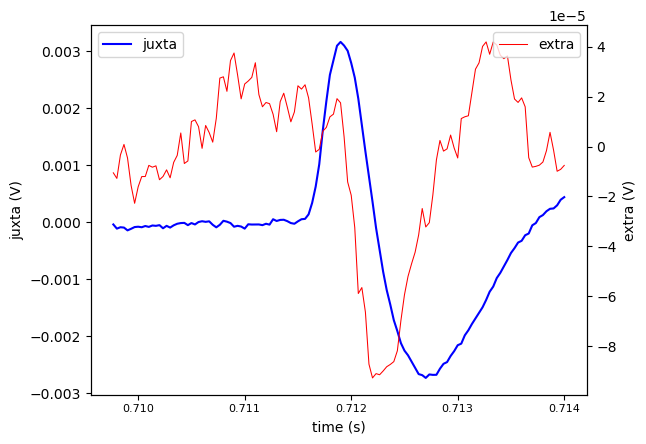

In [59]:
### Plot a single spike -- compare juxta with extracellular recordings for a given channel
import matplotlib.pyplot as plt
spike_i = 2
window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size + int(window_half_size % 2 == 1))
ax_juxta = plt.subplot(111)
ax_extra = ax_juxta.twinx()
ax_juxta.plot(window_ixs / Sampling_frequency, spike_data_in_V[window_ixs], c='b', label='juxta')

for extra_chan in [Probe_closest_electrode]:#range(Probe_numChannels):
    #ax_extra.plot(window_ixs / Sampling_frequency, extra_Volts[extra_chan,window_ixs], c='r', lw=0.75, label='extra')
    ax_extra.plot(window_ixs / Sampling_frequency, ivm_data_filtered[spike_i,extra_chan], c='r', lw=0.75, label='extra')

ax_juxta.set(xlabel='time (s)', ylabel='juxta (V)')
ax_extra.set(xlabel='time (s)', ylabel='extra (V)')
ax_juxta.tick_params(axis='x',labelsize=8)
ax_juxta.legend(loc='upper left')
ax_extra.legend(loc='upper right')

filtered extracellular data


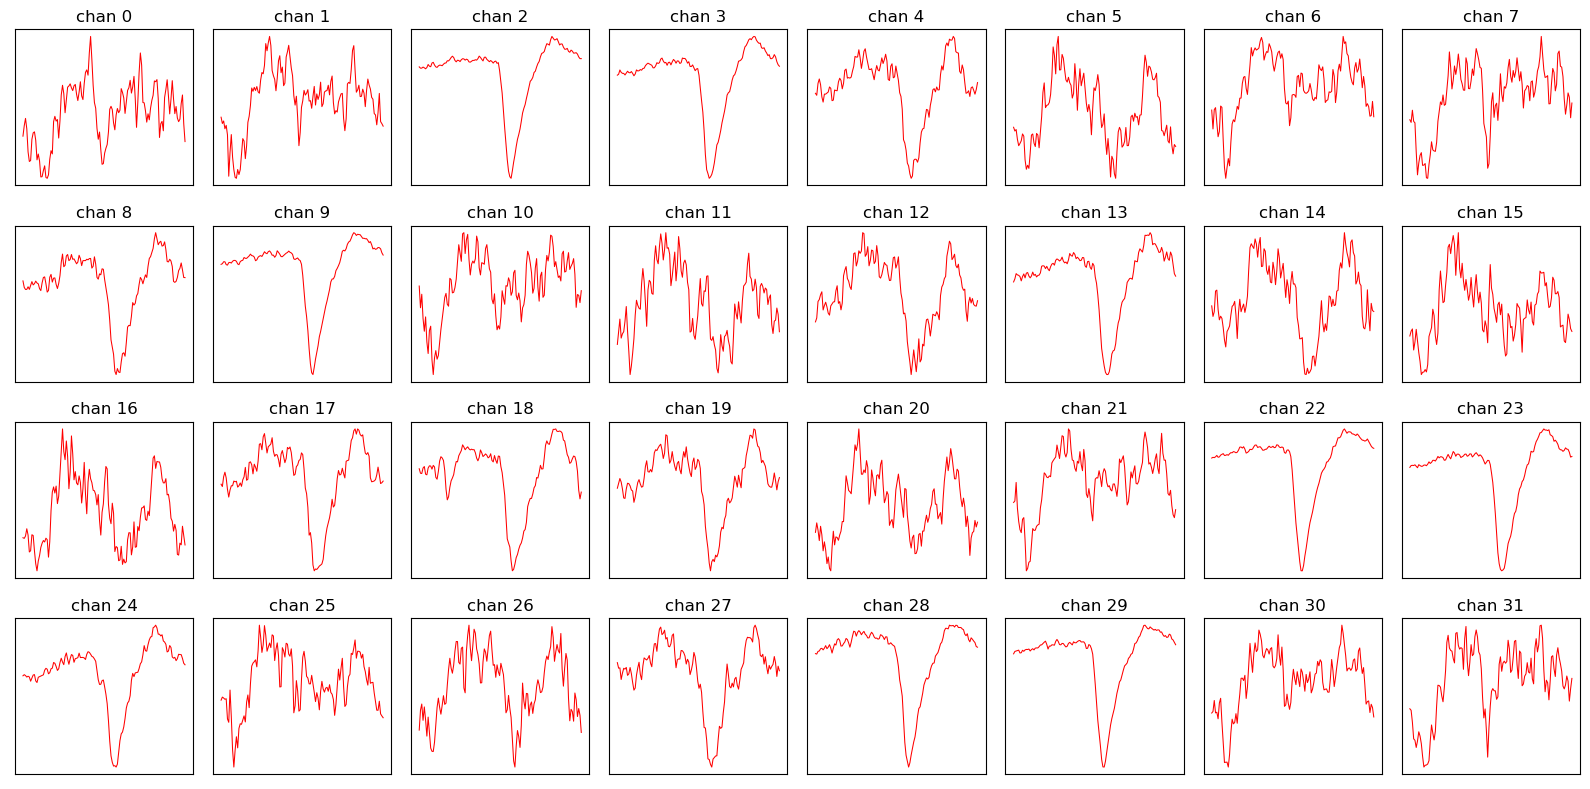

In [96]:
### Plot ALL channels each in a separate subplot within a time window around a juxta spike
## FILTERED DATA

spike_i = 2

ncols = 8
nrows = int(np.ceil(Probe_numChannels/ncols))
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))


window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))


for chan_i in range(Probe_numChannels):
    ax = axes.ravel()[chan_i]
    ax.plot(window_ixs / Sampling_frequency, ivm_data_filtered[spike_i,chan_i], c='r', lw=0.75, label='extra')
    ax.set(xticks=[], yticks=[], title=f'chan {chan_i}')
    
f.tight_layout()
print('filtered extracellular data')
plt.show()

unfiltered extracellular data


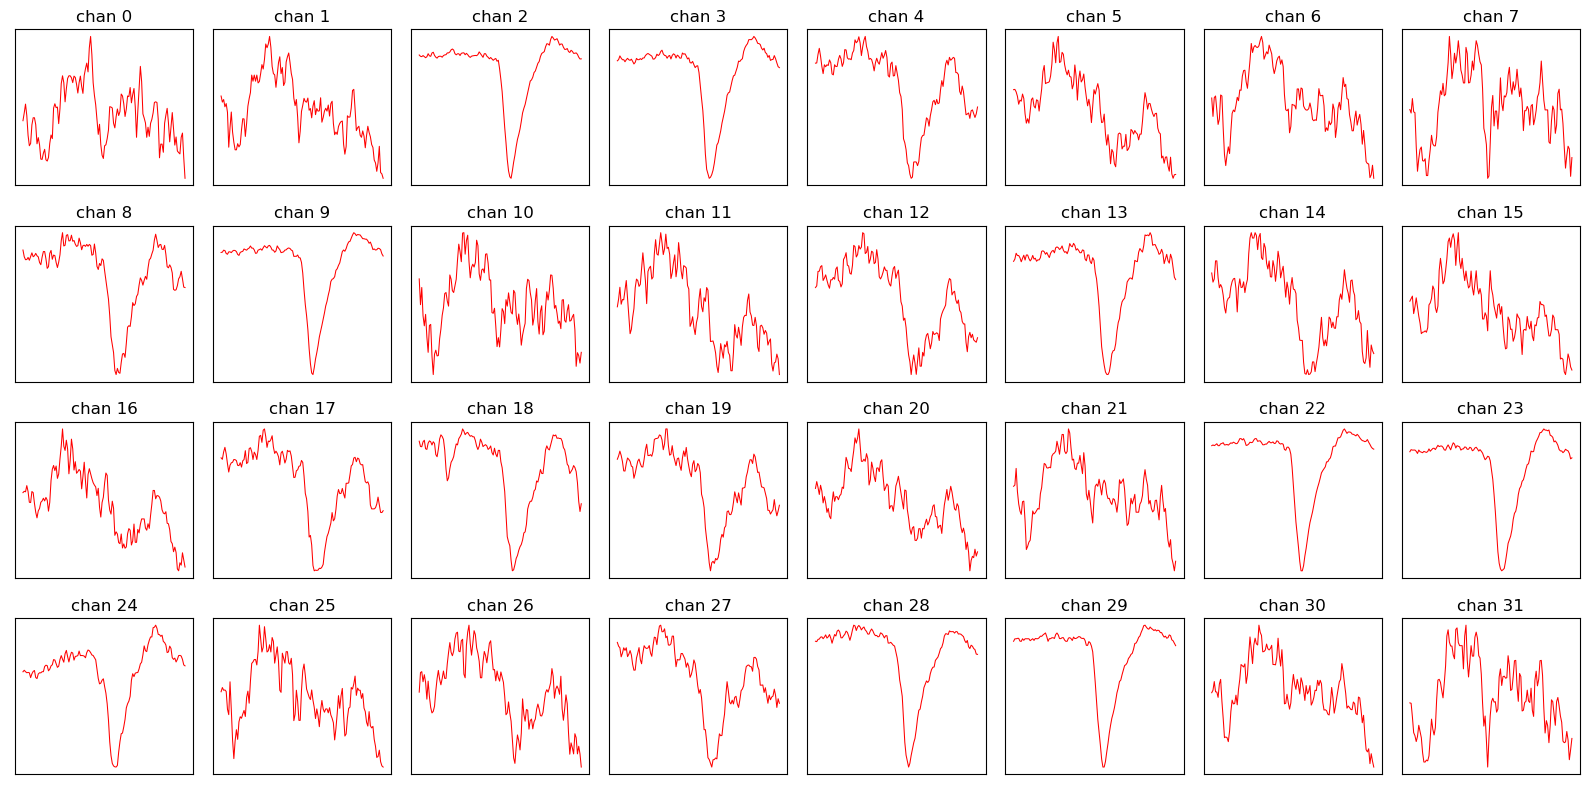

In [97]:
### Plot ALL channels each in a separate subplot within a time window around a juxta spike
## UNFILTERED DATA

spike_i = 2

ncols = 8
nrows = int(np.ceil(Probe_numChannels/ncols))
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))

# # get common y scale for all channels?
# ymin, ymax = extra_Volts[:,window_ixs].min(), extra_Volts[:,window_ixs].max()

for chan_i in range(Probe_numChannels):
    ax = axes.ravel()[chan_i]

    ax.plot(window_ixs / Sampling_frequency, extra_Volts[chan_i,window_ixs], c='r', lw=0.75, label='extra')
    
    ax.set(xticks=[], yticks=[], title=f'chan {chan_i}')
#     ax.set(ylim=(ymin, ymax))
f.tight_layout()
print('unfiltered extracellular data')
plt.show()

unfiltered extracellular data


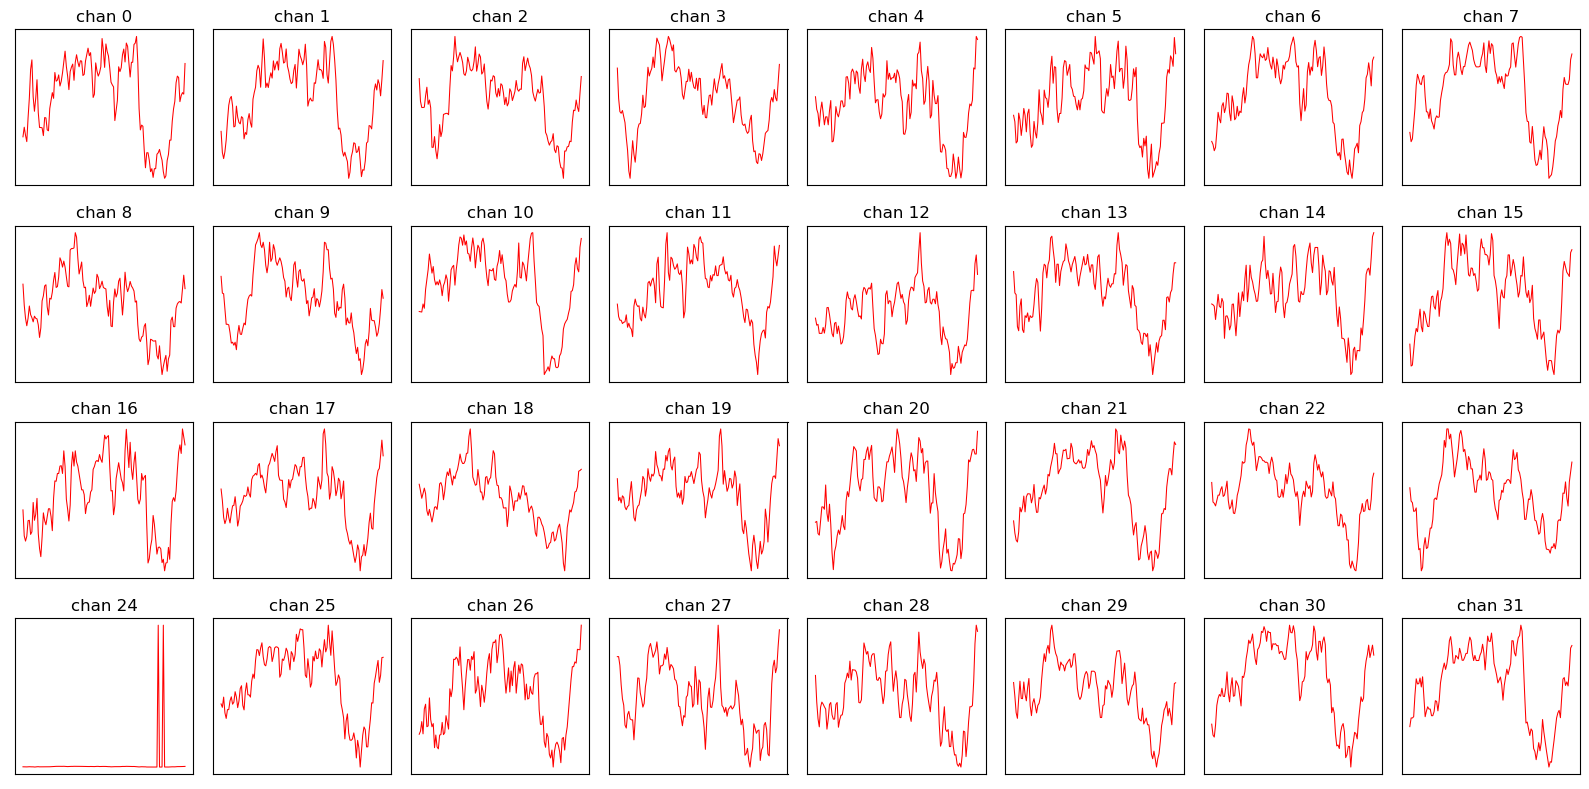

In [80]:
### Plot ALL channels each in a separate subplot within a time window around a juxta spike
## UNFILTERED DATA

spike_i = 0

ncols = 8
nrows = int(np.ceil(Probe_numChannels/ncols))
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))

# # get common y scale for all channels?
# ymin, ymax = extra_Volts[:,window_ixs].min(), extra_Volts[:,window_ixs].max()

for chan_i in range(Probe_numChannels):
    ax = axes.ravel()[chan_i]

    ax.plot(window_ixs / Sampling_frequency, extra_Volts[chan_i,window_ixs], c='r', lw=0.75, label='extra')
    
    ax.set(xticks=[], yticks=[], title=f'chan {chan_i}')
#     ax.set(ylim=(ymin, ymax))
f.tight_layout()
print('unfiltered extracellular data')
plt.show()

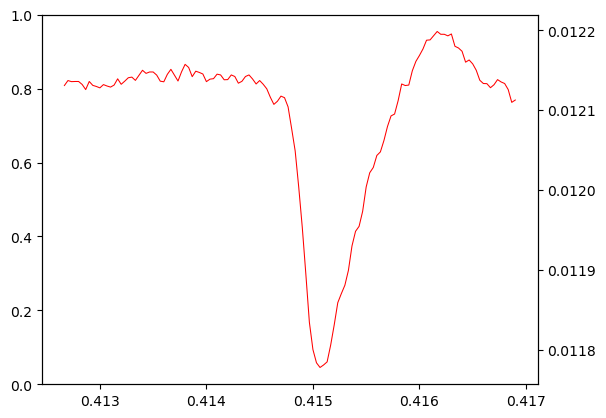

In [83]:
chan_i = 23
spike_i = 2
ax = plt.subplot(111)
#ax.plot(window_ixs / Sampling_frequency, extra_Volts[chan_i,window_ixs], c='r', lw=0.75, label='extra')
ax_ = ax.twinx()
ax_.plot(window_ixs / Sampling_frequency, ivm_data_unfiltered[spike_i,chan_i], c='r', lw=0.75, label='extra')

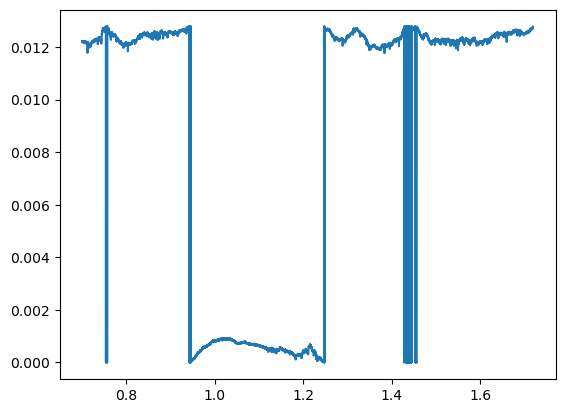

In [28]:
chan = 23
start_t = 0.70
end_t = 1.72
t_ixs = np.arange(round(start_t*Sampling_frequency),round(end_t*Sampling_frequency))
plt.plot(t_ixs/Sampling_frequency, extra_Volts[chan,t_ixs])

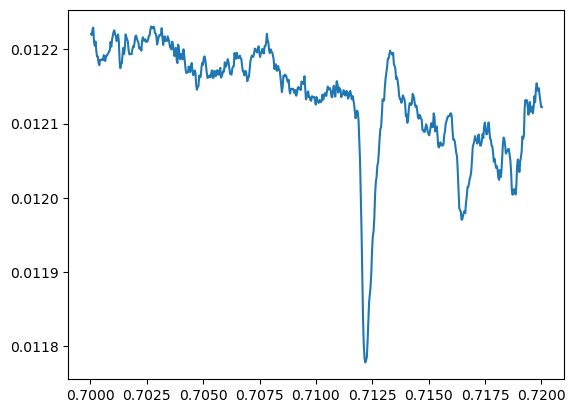

In [20]:
chan = 23
start_t = 0.70
duration_secs = 0.72
t_ixs = np.arange(round(start_t*Sampling_frequency),round(start_t+duration_secs*Sampling_frequency))
plt.plot(start_t/Sampling_frequency + t_ixs/Sampling_frequency, extra_Volts[chan,t_ixs])

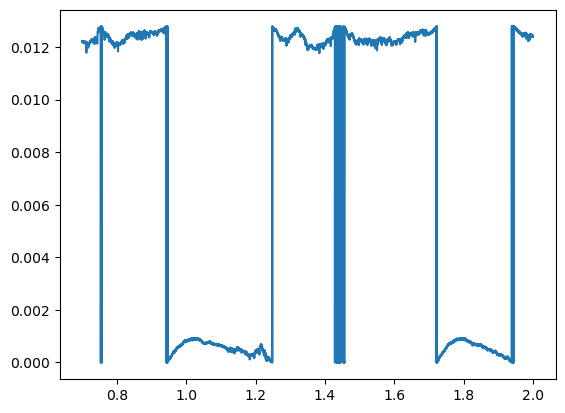

In [44]:
chan = 23
start_t = 0.70
duration_secs = 2
t_ixs = np.arange(round(start_t*Sampling_frequency),round(start_t+duration_secs*Sampling_frequency))
plt.plot(start_t/Sampling_frequency + t_ixs/Sampling_frequency, extra_Volts[chan,t_ixs])

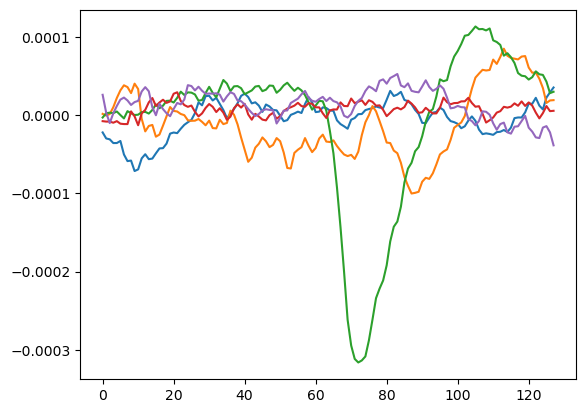

In [30]:
# check the Volt scale for the first 5 spikes of a certain channel
chan = 23
plt.plot(ivm_data_filtered[:5,chan,:].T)

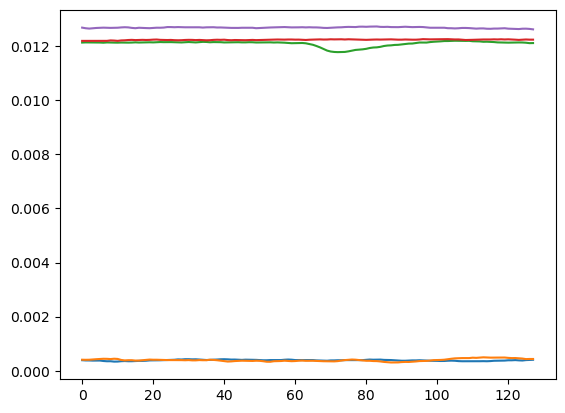

In [57]:
# check the Volt scale for the first 5 spikes of a certain channel
chan = 23
plt.plot(ivm_data_unfiltered[:5,chan,:].T)

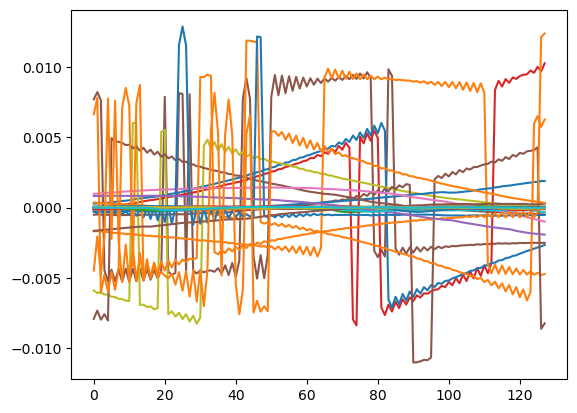

In [31]:
# check the Volt scale for the first 100 spikes of a certain channel
chan = 23
plt.plot(ivm_data_filtered[:100,chan,:].T);

(array([1.741e+03, 3.500e+01, 3.100e+01, 1.300e+01, 8.000e+00, 3.000e+00,
        4.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.700e+01, 3.800e+01, 2.700e+01, 1.900e+01, 1.300e+01,
        1.500e+01, 5.000e+00]),
 array([3.73993571e-05, 1.01037975e-03, 1.98336015e-03, 2.95634056e-03,
        3.92932072e-03, 4.90230136e-03, 5.87528152e-03, 6.84826216e-03,
        7.82124233e-03, 8.79422296e-03, 9.76720359e-03, 1.07401833e-02,
        1.17131639e-02, 1.26861446e-02, 1.36591252e-02, 1.46321049e-02,
        1.56050855e-02, 1.65780652e-02, 1.75510459e-02, 1.85240265e-02,
        1.94970071e-02], dtype=float32),
 <BarContainer object of 20 artists>)

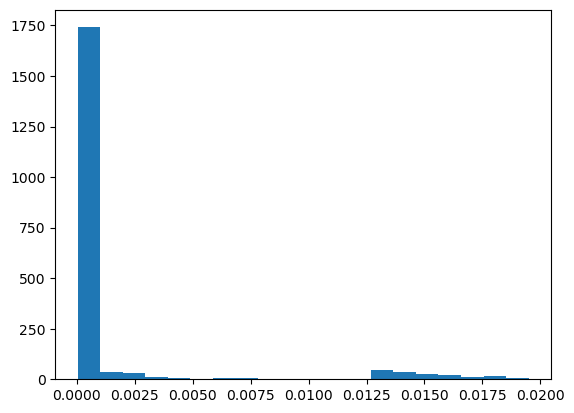

In [68]:
# plot distribution of ranges for all windows around true spikes

chan = 23

all_ranges = ivm_data_filtered[:,chan,:].max(1) - ivm_data_filtered[:,chan,:].min(1)
plt.hist( all_ranges, 20 )

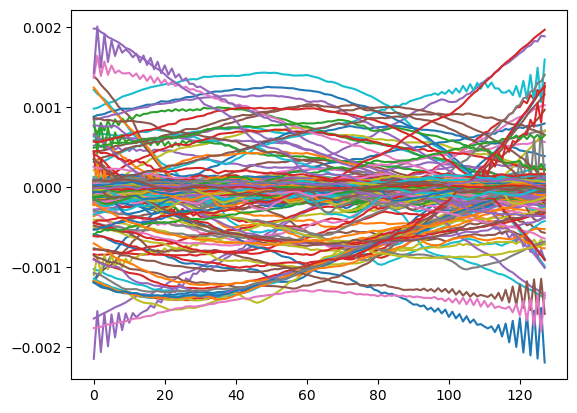

In [40]:
good_ones = np.flatnonzero(all_ranges < .0025)
chan = 23
plt.plot(ivm_data_filtered[good_ones,chan,:].T);

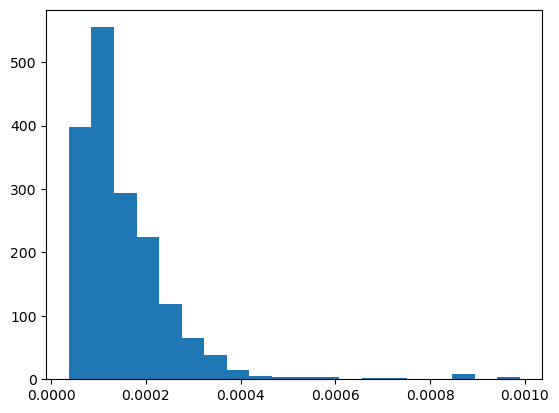

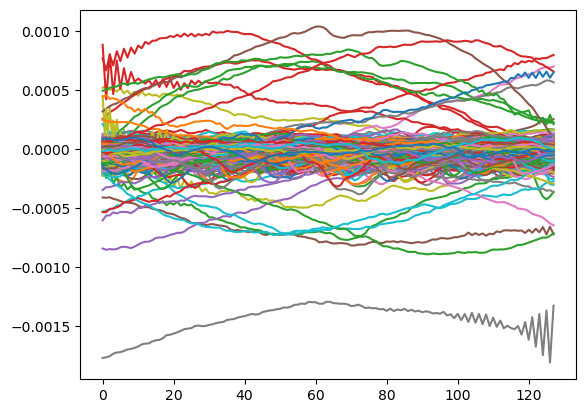

In [43]:
good_ones = np.flatnonzero(all_ranges < .001)
plt.hist( all_ranges[good_ones], 20 )
plt.show()
plt.plot(ivm_data_filtered[good_ones,chan,:].T);

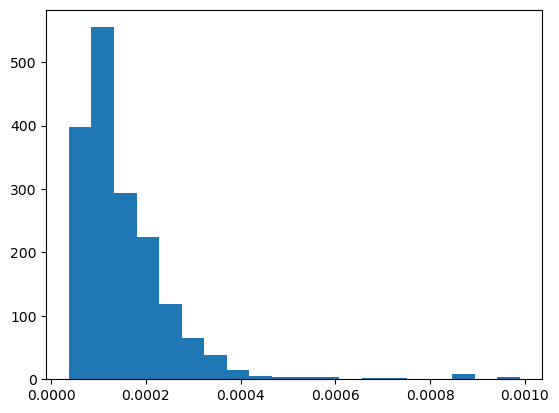

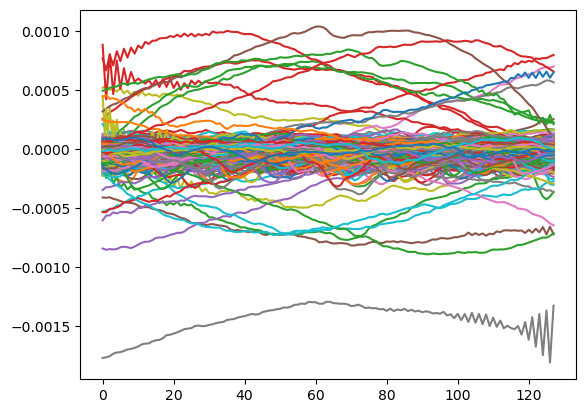

In [43]:
good_ones = np.flatnonzero(all_ranges < .001)
plt.hist( all_ranges[good_ones], 20 )
plt.show()
plt.plot(ivm_data_filtered[good_ones,chan,:].T);

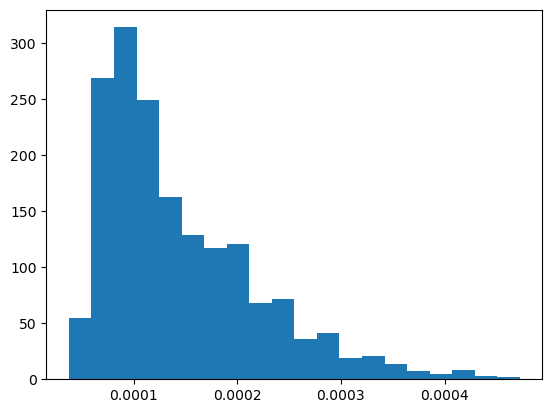

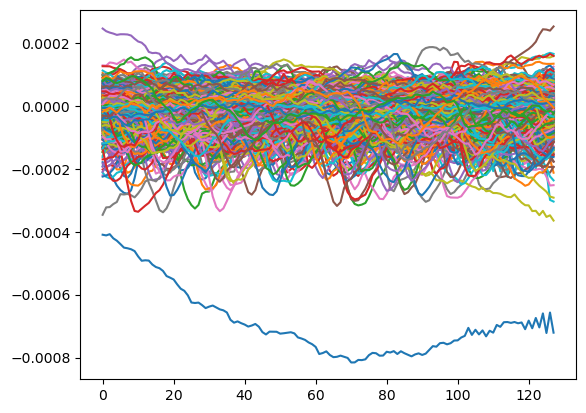

In [71]:
good_ones = np.flatnonzero(all_ranges < .0005)
plt.hist( all_ranges[good_ones], 20 )
plt.show()
plt.plot(ivm_data_filtered[good_ones,chan,:].T);

(array([1840.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  164.]),
 array([4.67998907e-05, 6.83426159e-04, 1.32005243e-03, 1.95667869e-03,
        2.59330496e-03, 3.22993123e-03, 3.86655750e-03, 4.50318377e-03,
        5.13981003e-03, 5.77643630e-03, 6.41306257e-03, 7.04968884e-03,
        7.68631510e-03, 8.32294137e-03, 8.95956764e-03, 9.59619391e-03,
        1.02328202e-02, 1.08694464e-02, 1.15060727e-02, 1.21426990e-02,
        1.27793252e-02]),
 <BarContainer object of 20 artists>)

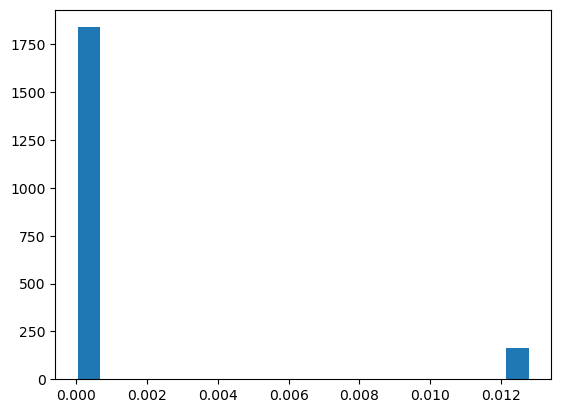

In [60]:
# plot distribution of ranges for all windows around true spikes

chan = 23

all_ranges_unfiltered = ivm_data_unfiltered[:,chan,:].max(1) - ivm_data_unfiltered[:,chan,:].min(1)
plt.hist( all_ranges_unfiltered, 20 )

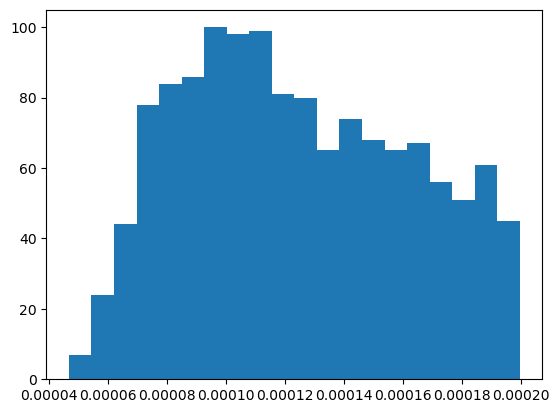

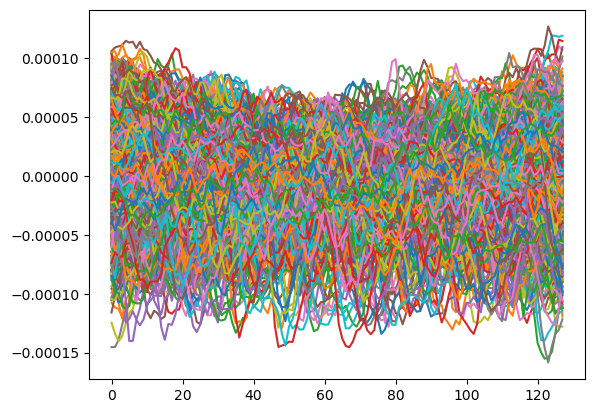

In [63]:
good_ones = np.flatnonzero(all_ranges_unfiltered < .0002)
plt.hist( all_ranges_unfiltered[good_ones], 20 )
plt.show()
plt.plot((ivm_data_unfiltered[good_ones,chan,:] - ivm_data_unfiltered[good_ones,chan,:].mean(1)[:,None]).T);

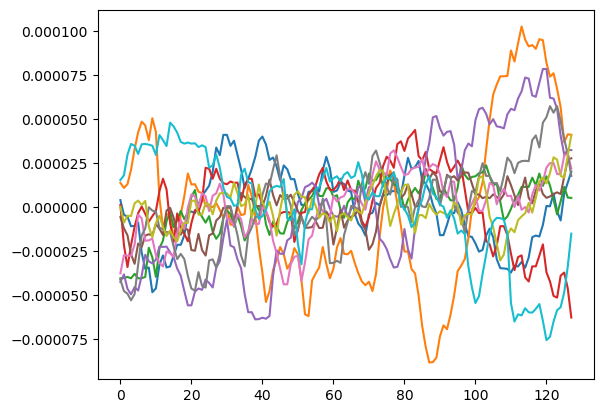

In [84]:
chan = 23

all_ranges_unfiltered = ivm_data_unfiltered[:,chan,:].max(1) - ivm_data_unfiltered[:,chan,:].min(1)

good_ones = np.flatnonzero(all_ranges_unfiltered < .0004)
plt.plot((ivm_data_unfiltered[good_ones[:10],chan,:] - ivm_data_unfiltered[good_ones[:10],chan,:].mean(1)[:,None]).T);

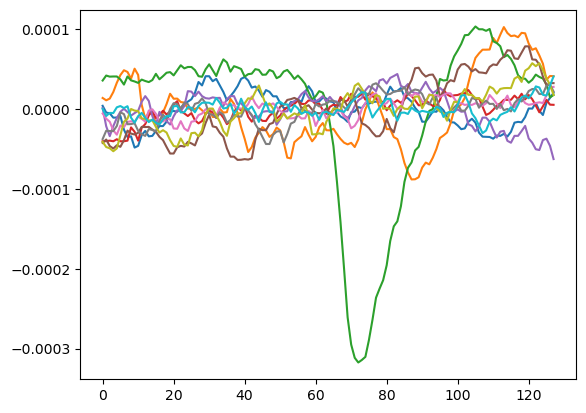

In [104]:
which_channel = 23
which_spikes = [0,1,2,3,4,6,7,8,9,10]
plt.plot((ivm_data_unfiltered[which_spikes][:,which_channel] - ivm_data_unfiltered[which_spikes][:,which_channel].mean(1,keepdims=1)).T);